# Geospatical Area Perimeter Estimation

## Introduction

In this project, we utilize the SpaceNet dataset to estimate the area and perimeter of buildings visible in satellite imagery. The SpaceNet dataset comprises georeferenced satellite images, organized into tiles where each tile represents a 200x200 meter square. The images are provided in GeoTIFF format, ensuring accurate spatial referencing, and in RGB-PanSharpen format, which merges the high-resolution panchromatic band with the red, green, and blue multispectral bands. This combination not only enhances resolution but also enriches the imagery with detailed color information.

The choice to use RGB-PanSharpen data for building footprint extraction is strategic. The panchromatic band delivers superior resolution compared to standard multispectral data, while the incorporation of RGB channels adds valuable context that a single band cannot provide.

To compute the area and perimeter of each building, we first determine the Ground Sample Distance (GSD), which is the distance between the centers of adjacent pixels measured on the ground. The GSD is calculated by dividing the width of the image in meters by the number of pixels along that width. Given that each tile covers 200 meters and the original images are 650x650 pixels, we resize the images to 640x640 pixels—this adjustment ensures compatibility with our model, as 640 is a multiple of 32. With this configuration, the GSD is 0.3125 meters.

## Approach

Since we have the GSD, image size, and mask. All we need to do to estimate size is create a model that generate a mask for the buildings in the image. Then we can calculate the area and perimeter of the buildings in the mask.

1. Load the TIFF images and corresponding building footprints (GeoJSON).
2. Preprocess the images (resize, normalize, augment).
3. Convert footprints into binary masks (rasterize GeoJSON).
4. Train a segmentation model (ResNeXt + UNet).
5. Compute area and perimeter from the predicted mask.
6. Post processing to display images with their masks.

## Imports 

In [ ]:
!pip install geopandas rasterio albumentations

In [ ]:
!pip install segmentation_models

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import re
import glob
import rasterio
import albumentations as A

os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
import segmentation_models as sm

from skimage.measure import label, regionprops
from rasterio.transform import Affine
from rasterio import features
from rasterio.warp import reproject, Resampling

2025-02-03 18:45:59.211617: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 18:45:59.215064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 18:45:59.226594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738608359.246170    1647 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738608359.252034    1647 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 18:45:59.271675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Segmentation Models: using `tf.keras` framework.


## Download Dataset

In [4]:
%%bash
aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/AOI_2_Vegas_Test_public.tar.gz dataset/backups/

download: s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/AOI_2_Vegas_Test_public.tar.gz to dataset/backups/AOI_2_Vegas_Test_public.tar.gz


In [5]:
%%bash
aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz dataset/backups/

download: s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz to dataset/backups/SN2_buildings_train_AOI_2_Vegas.tar.gz


In [6]:
%%bash
tar -xzf dataset/backups/AOI_2_Vegas_Test_public.tar.gz -C dataset/

In [7]:
%%bash
tar -xzf dataset/backups/SN2_buildings_train_AOI_2_Vegas.tar.gz -C dataset/

## Preprocessing

* each image should be 650x650 pixels but converted to 640x640
* Normalize pixel values to a range 0-255 for normal viewing

In [3]:
# Paths to training and testing datasets

# Train Images and Masks
train_folder = "dataset/AOI_2_Vegas_Train/RGB-PanSharpen"
train_masks_folder  = "dataset/AOI_2_Vegas_Train/geojson/buildings"

# Processed Training Images and Masks
processed_train_folder = "dataset/processed_images/AOI_2_Vegas_Train/RGB-PanSharpen-processed"
processed_mask_folder = "dataset/processed_masks/AOI_2_Vegas_Train/geojson"

# Test Images
test_folder = "dataset/AOI_2_Vegas_Test_public/RGB-PanSharpen"
processed_test_folder = "dataset/processed_images/AOI_2_Vegas_Test_public/RGB-PanSharpen-processed"

In [11]:
os.makedirs(processed_train_folder, exist_ok=True)
os.makedirs(processed_test_folder,  exist_ok=True)
os.makedirs(processed_mask_folder,  exist_ok=True)

In [12]:
def normalize_band(band):
    """Normalize a band to [0, 255] while avoiding zero-range scaling issues."""
    band_min, band_max = band.min(), band.max()
    if band_max == band_min:
        return np.full_like(band, 128, dtype=np.uint8)  # Mid-gray if all values are identical
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)

In [13]:
def preprocess_tiff(image_path, out_folder):
    """
    Preprocess a TIFF image:
    1. Reads each band and normalizes it to [0, 255] using an external normalize_band function.
    2. Resamples to 640×640 using bilinear interpolation while **maintaining the original bounding box.
    3. Saves as uint8 GeoTIFF in 'out_folder'.
    4. Returns the processed image path.
    """
    os.makedirs(out_folder, exist_ok=True)
    filename = os.path.basename(image_path)
    out_path = os.path.join(out_folder, filename)

    with rasterio.open(image_path, "r") as src:
        meta = src.meta.copy()
        original_transform = src.transform
        original_crs = src.crs
        original_width, original_height = src.width, src.height

        # Target size (fixed to 640x640)
        target_width, target_height = 640, 640

        # Compute new pixel size so the bounding box remains unchanged
        new_pixel_size_x = (original_transform.a * original_width) / float(target_width)
        new_pixel_size_y = (original_transform.e * original_height) / float(target_height)

        # Preserve original bounding box (top-left corner stays fixed)
        new_transform = Affine(
            new_pixel_size_x, 
            original_transform.b, 
            original_transform.c,
            original_transform.d, 
            new_pixel_size_y, 
            original_transform.f
        )

        # print(f"[INFO] Resizing {filename}: {original_width}x{original_height} -> {target_width}x{target_height}")
        # print(f"[INFO] Keeping bounding box from {original_transform.c, original_transform.f}")

        # Prepare array for resized bands
        resized_bands = np.zeros((src.count, target_height, target_width), dtype=np.uint8)

        # Reproject each band
        for i in range(src.count):
            source_band = normalize_band(src.read(i + 1))
            destination = np.empty((target_height, target_width), dtype=np.float32)

            reproject(
                source=source_band,
                destination=destination,
                src_transform=original_transform,
                src_crs=original_crs,
                dst_transform=new_transform,
                dst_crs=original_crs,
                resampling=Resampling.bilinear
            )

            np.clip(destination, 0, 255, out=destination)  # Clamp values to avoid overflow
            resized_bands[i] = destination.astype(np.uint8)

        # Update metadata
        meta.update({
            "width": target_width,
            "height": target_height,
            "dtype": "uint8",
            "transform": new_transform,
            "crs": original_crs
        })

        with rasterio.open(out_path, "w", **meta) as dst:
            for i in range(resized_bands.shape[0]):
                dst.write(resized_bands[i], i + 1)

    # print(f"[INFO] Saved preprocessed image: {out_path}")
    return out_path

In [14]:
def augement_tiff(image_path, mask_path):
    """
    Augments a preprocessed TIFF image and its corresponding mask in place.
    
    The augmentation pipeline includes horizontal flip, vertical flip, random 90° rotations,
    and random brightness/contrast adjustments (applied only to the image).
    
    Parameters:
        image_path (str): Path to the preprocessed TIFF image.
        mask_path (str): Path to the mask TIFF image.
    """
    import os
    import numpy as np
    import rasterio
    import albumentations as A

    # Read the preprocessed image with rasterio.
    with rasterio.open(image_path, "r") as src:
        image_meta = src.meta.copy()
        # Image data shape: (channels, height, width)
        image_data = src.read()
    
    # Read the mask (assuming a single-band mask).
    with rasterio.open(mask_path, "r") as src:
        mask_meta = src.meta.copy()
        # Mask data shape: (height, width)
        mask_data = src.read(1)
    
    # Convert image data from (channels, height, width) to (height, width, channels) for Albumentations.
    image_data = np.transpose(image_data, (1, 2, 0))
    
    # Define the augmentation pipeline.
    # The 'mask' is registered as an additional target so that spatial transforms are applied identically.
    aug_pipeline = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        # Brightness/contrast adjustments are applied only to the image.
        A.RandomBrightnessContrast(p=0.5)
    ], additional_targets={'mask': 'mask'})
    
    # Apply the augmentation.
    augmented = aug_pipeline(image=image_data, mask=mask_data)
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']
    
    # Convert augmented image back to (channels, height, width) for saving.
    augmented_image = np.transpose(augmented_image, (2, 0, 1))
    
    # Overwrite the original image with the augmented image.
    with rasterio.open(image_path, "w", **image_meta) as dst:
        dst.write(augmented_image)
    
    # Overwrite the original mask with the augmented mask.
    with rasterio.open(mask_path, "w", **mask_meta) as dst:
        dst.write(augmented_mask, 1)
    
    # print(f"[INFO] Augmented image saved in place: {image_path}")
    # print(f"[INFO] Augmented mask saved in place: {mask_path}")
    
    # return image_path, mask_path

In [15]:
def rasterize_geojson(geojson_path, reference_tif_path, out_mask_path, all_touched=True):
    """
    Rasterizes a GeoJSON file to match the width, height, transform, and CRS of a reference TIFF.
    - Converts GeoJSON CRS if needed before rasterizing.
    - Outputs a single-band, dtype=uint8 mask where:
        1 = building footprint, 0 = background.
    """

    if not os.path.isfile(geojson_path):
        print(f"[Warning] GeoJSON not found: {geojson_path}")
        return
    if not os.path.isfile(reference_tif_path):
        print(f"[Warning] Reference TIFF not found: {reference_tif_path}")
        return

    # Open reference (resized) TIFF
    with rasterio.open(reference_tif_path) as ref_src:
        ref_transform = ref_src.transform
        ref_crs = ref_src.crs
        width, height = ref_src.width, ref_src.height

    # print(f"[INFO] Processing mask for {geojson_path}")
    # print(f"[INFO] Reference: {reference_tif_path}")
    # print(f"[INFO] Transform: {ref_transform}")
    # print(f"[INFO] Size: {width}x{height}")

    # Load GeoJSON
    gdf = gpd.read_file(geojson_path)

    # Ensure CRS matches
    if gdf.crs != ref_crs:
        print(f"[INFO] CRS mismatch: GeoJSON ({gdf.crs}) vs TIFF ({ref_crs}). Reprojecting...")
        gdf = gdf.to_crs(ref_crs)

    # Prepare (geometry, value) pairs
    shapes = [(geom, 1) for geom in gdf.geometry if geom is not None]

    # Rasterize
    mask_array = features.rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=ref_transform,
        fill=0,
        all_touched=all_touched,
        dtype=np.uint8
    )

    print("Unique values in mask after rasterization:", np.unique(mask_array))

    # Save mask
    mask_meta = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "uint8",
        "crs": ref_crs,
        "transform": ref_transform
    }

    with rasterio.open(out_mask_path, "w", **mask_meta) as dst:
        dst.write(mask_array, 1)

    # print(f"[INFO] Mask saved: {out_mask_path}")

In [16]:
def preprocess_folder_images_only(in_image_folder, out_image_folder):
    """
    Preprocess each TIFF in 'in_image_folder' (normalize, resample) and save to 'out_image_folder'.
    No GeoJSON handling.
    """
    os.makedirs(out_image_folder, exist_ok=True)

    for file in os.listdir(in_image_folder):
        if file.endswith(".tif"):
            tiff_path = os.path.join(in_image_folder, file)
            print(f"Preprocessing: {tiff_path}")
            preprocess_tiff(tiff_path, out_image_folder)

    print(f"\nAll TIFFs in {in_image_folder} have been processed.")
    print(f"Processed images in: {out_image_folder}")

In [17]:
def preprocess_folder_images_and_geojsons(
    in_image_folder, out_image_folder,
    in_geojson_folder, out_geojson_folder
):
    """
    Processes each TIFF in 'in_image_folder' by:
      1) Preprocessing the image (resizes to 650×650).
      2) Finding a corresponding GeoJSON.
      3) Rasterizing the GeoJSON to a mask.
    """

    os.makedirs(out_image_folder, exist_ok=True)
    os.makedirs(out_geojson_folder, exist_ok=True)

    for file in os.listdir(in_image_folder):
        if file.lower().endswith(".tif"):
            tiff_path = os.path.join(in_image_folder, file)

            # 1) Preprocess the TIFF
            out_tiff_path = preprocess_tiff(tiff_path, out_image_folder)

            # 2) Match the corresponding GeoJSON by "imgXXXX"
            match = re.search(r"img\d+", file)
            if not match:
                print(f"[Warning] Could not extract 'imgXXXX' from filename: {file}")
                continue

            img_id = match.group(0)
            matched_geojson = next(
                (gf for gf in os.listdir(in_geojson_folder) if gf.lower().endswith(".geojson") and img_id in gf), None
            )

            if not matched_geojson:
                print(f"[Warning] No GeoJSON found for {file}")
                continue

            geojson_path = os.path.join(in_geojson_folder, matched_geojson)
            out_mask_name = os.path.splitext(file)[0] + "_mask.tif"
            out_mask_path = os.path.join(out_geojson_folder, out_mask_name)

            # 3) Rasterize the GeoJSON to match the TIFF
            rasterize_geojson(geojson_path, out_tiff_path, out_mask_path)
            
            # 4) Augment the preprocessed image and mask in place
            augement_tiff(out_tiff_path, out_mask_path)

    print(f"\n[INFO] Processed TIFFs: {out_image_folder}")
    print(f"[INFO] Rasterized masks: {out_geojson_folder}")

In [ ]:
# Run preprocessing on training and testing datasets
preprocess_folder_images_and_geojsons(
    train_folder,
    processed_train_folder,
    train_masks_folder,
    processed_mask_folder
)

In [ ]:
preprocess_folder_images_only(
    test_folder,
    processed_test_folder
)

In [20]:
def visualize_mask(mask_path):
    """
    Reads the single-band mask (0/1), rescales it to [0,255], and displays it in Matplotlib.
    """
    with rasterio.open(mask_path) as src:
        mask_data = src.read(1)  # single band -> shape: (height, width)

    # Rescale from [0,1] to [0,255]
    scaled_mask = (mask_data * 255).astype(np.uint8)

    # Plot
    # plt.figure(figsize=(6,6))
    plt.imshow(scaled_mask, cmap='gray')
    plt.title("Mask Visualization (Rescaled)")
    plt.axis('off')  # hide axes
    plt.show()

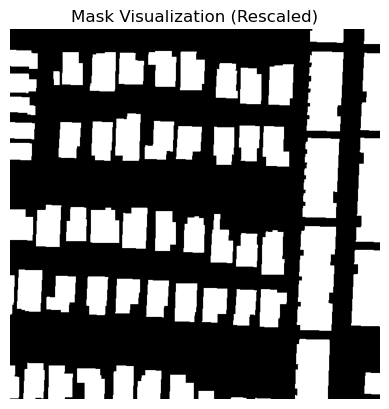

In [21]:
mask_file = "dataset/processed_masks/AOI_2_Vegas_Train/geojson/RGB-PanSharpen_AOI_2_Vegas_img1070_mask.tif"
visualize_mask(mask_file)

## Loading Data

In [6]:
train_images = []
train_masks = []

In [5]:
def load_images_and_masks(images_folder, masks_folder):
    """
    Loads preprocessed images and their corresponding masks into NumPy arrays.

    Assumes:
      - images_folder contains .tif image files
      - masks_folder contains .tif mask files
      - Each image "FILE.tif" has a corresponding "FILE_mask.tif" in masks_folder

    Returns:
      X: np.array of shape (N, H, W, C)  [images]
      Y: np.array of shape (N, H, W, 1)  [masks]
    """
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.tif")))
    X_list = []
    Y_list = []

    for img_path in image_paths:
        # 1) Read the image
        with rasterio.open(img_path) as src_img:
            img_data = src_img.read()  # (bands, height, width)
            img_data = np.transpose(img_data, (1, 2, 0))  # -> (height, width, bands)

        # 2) Build the expected mask filename
        base_name = os.path.splitext(os.path.basename(img_path))[0]  # e.g. "RGB-PanSharpen_AOI_2_Vegas_img4817"
        mask_name = base_name + "_mask.tif"                           # e.g. "RGB-PanSharpen_AOI_2_Vegas_img4817_mask.tif"
        mask_path = os.path.join(masks_folder, mask_name)

        # 3) Read the mask if it exists; else create a blank mask
        if os.path.exists(mask_path):
            with rasterio.open(mask_path) as src_mask:
                mask_data = src_mask.read(1)  # single band -> (height, width)
        else:
            # create an empty mask if none found
            h, w, _ = img_data.shape
            mask_data = np.zeros((h, w), dtype=np.uint8)

        X_list.append(img_data.astype(np.float32))
        Y_list.append(mask_data.astype(np.uint8))

    # Convert to NumPy arrays
    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.uint8)

    # Expand dims so mask has shape (N, H, W, 1) if required by your model
    Y = np.expand_dims(Y, axis=-1)

    return X, Y


In [6]:
# Load training data

X_train, Y_train = load_images_and_masks(processed_train_folder, processed_mask_folder)

In [7]:
print("train_images.shape:", X_train.shape)
print("train_masks.shape:", Y_train.shape)

train_images.shape: (3851, 640, 640, 3)
train_masks.shape: (3851, 640, 640, 1)


## Modeling

In [8]:
sm.framework()  # just to confirm

'tf.keras'

In [9]:
# We use 'resnext50' as the encoder backbone
# classes=1 for building vs background
# activation='sigmoid' for binary segmentation
# encoder_weights='imagenet' to leverage pretraining
model_resnext = sm.Unet(
    backbone_name='resnext50',
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet',
    input_shape=(640, 640, 3)
)

In [ ]:
# Compile
model_resnext.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# model_resnext.summary()

In [ ]:
history = model_resnext.fit(
    X_train, Y_train,
    epochs=3,
    batch_size=2,
    validation_split=0.25
)

2025-02-03 18:48:37.143185: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14195097600 exceeds 10% of free system memory.


Epoch 1/3
 513/1444 ━━━━━━━━━━━━━━━━━━━━ 52:39 3s/step - accuracy: 0.8527 - loss: 0.3485

In [ ]:
os.makedirs("outputs", exist_ok=True)
model_save_path = os.path.join("outputs", "unet_resnext_building_extractionV2.h5")

model_resnext.save(model_save_path)
print(f"Model saved to: {model_save_path}")

## Inference

In [ ]:
# Define model path
model_path = os.path.join("outputs", "unet_resnext_building_extractionV2.h5")

# Load trained model
model_resnext = load_model(model_path)
print(f"Model loaded from: {model_path}")

In [92]:
def load_images_only(images_folder):
    """
    Loads preprocessed images into a NumPy array.

    Args:
      images_folder (str): Directory containing .tif image files.

    Returns:
      X (np.ndarray): Array of shape (N, H, W, C), 
                      where N = number of images, 
                            H, W = image dimensions,
                            C = number of channels (bands).
    """
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.tif")))
    X_list = []

    for img_path in image_paths:
        with rasterio.open(img_path) as src_img:
            # Read all bands: shape -> (bands, height, width)
            img_data = src_img.read()
            # Transpose to (height, width, bands) for consistency
            img_data = np.transpose(img_data, (1, 2, 0))
            X_list.append(img_data.astype(np.float32))

    # Convert the list of arrays to a single NumPy array
    X = np.array(X_list, dtype=np.float32)
    return X

In [93]:
# Load test images
X_test = load_images_only(processed_test_folder)
print("X_train.shape ", X_train.shape)

X_train.shape  (3851, 640, 640, 3)


In [94]:
preds = model_resnext.predict(X_test)  # shape: (N, 640, 640, 3)
binary_preds = (preds > 0.5).astype('uint8')

41/41 ━━━━━━━━━━━━━━━━━━━━ 299s 7s/step


## Area and Perimeter Calculation

In [95]:
GSD = 0.31

def compute_area_perimeter(mask_2d, pixel_size=GSD):
    """
    mask_2d: np.array of shape (H, W), binary (0/1)
    pixel_size: ground sampling distance in meters/pixel
    """
    labeled = label(mask_2d)  # identify connected components
    results = []

    for region in regionprops(labeled):
        area_px = region.area
        perimeter_px = region.perimeter

        # Convert to real-world
        area_m2 = area_px * (pixel_size ** 2)
        perimeter_m = perimeter_px * pixel_size

        results.append({
            'label': region.label,
            'area_pixels': area_px,
            'perimeter_pixels': perimeter_px,
            'area_m2': area_m2,
            'perimeter_m': perimeter_m
        })

    return results

In [ ]:
for i in range(len(X_test)):
    mask_2d = binary_preds[i, :, :, 0]
    building_stats = compute_area_perimeter(mask_2d, pixel_size=GSD)
    print(f"Stats for Test Image {i+1}:")
    for stat in building_stats:
        print(stat)
    print("----------------")

In [97]:
print(f"binary_preds shape: {binary_preds.shape}")
print(f"X_test shape: {X_test.shape}")

binary_preds shape: (1282, 640, 640, 1)
X_test shape: (1282, 640, 640, 3)


## Postprocessing

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.measure import label, regionprops
from matplotlib.patches import Rectangle

GSD = 0.31  # Ground Sampling Distance (meters/pixel)

In [99]:
def compute_area_perimeter(mask_2d, pixel_size=GSD):
    """
    Computes area and perimeter of each connected building in the mask.

    Args:
        mask_2d (np.array): Binary mask (0 = background, 1 = building).
        pixel_size (float): Ground Sampling Distance (meters per pixel).

    Returns:
        List of dictionaries with 'label', 'area_m2', 'perimeter_m'.
    """
    labeled = label(mask_2d)  # Identify connected components
    results = []

    for region in regionprops(labeled):
        area_px = region.area
        perimeter_px = region.perimeter

        # Convert to real-world units
        area_m2 = round(area_px * (pixel_size ** 2), 2)
        perimeter_m = round(perimeter_px * pixel_size, 2)

        results.append({
            'label': region.label,
            'area_m2': area_m2,
            'perimeter_m': perimeter_m,
            'bbox': region.bbox  # Bounding box for annotations
        })

    return results, labeled

In [100]:
def overlay_mask_with_labels(image_path, mask_2d, alpha=0.4, mask_color='red'):
    """
    Displays an input image with a binary mask overlay and annotated building labels.

    Args:
        image_path (str): Path to the original geospatial TIFF image.
        mask_2d (np.array): 2D binary mask (0/1) to overlay.
        alpha (float): Transparency of the overlay (0 = fully transparent, 1 = fully opaque).
        mask_color (str): Color of the mask overlay (e.g., 'red', 'blue', 'green').
    """
    # Load the image
    with rasterio.open(image_path) as src:
        img_data = src.read()
        img_data = np.transpose(img_data, (1, 2, 0))  # Convert to (H, W, C)
        img_data = img_data.astype(np.float32) / 255.0  # Normalize for display

    # Define color mappings for the mask
    color_map = {
        'red': [1, 0, 0, alpha],
        'green': [0, 1, 0, alpha],
        'blue': [0, 0, 1, alpha],
        'yellow': [1, 1, 0, alpha],
        'cyan': [0, 1, 1, alpha]
    }

    # Select mask color (default is red)
    overlay_color = color_map.get(mask_color, [1, 0, 0, alpha])

    # Create an overlay mask (RGBA)
    mask_overlay = np.zeros((*mask_2d.shape, 4), dtype=np.float32)  # (H, W, 4)
    mask_overlay[mask_2d == 1] = overlay_color  # Apply color with transparency

    # Compute building properties
    building_stats, labeled_mask = compute_area_perimeter(mask_2d, pixel_size=GSD)

    # Plot Image + Overlay
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_data)  # Show original image
    ax.imshow(mask_overlay)  # Overlay mask with transparency

    # Annotate each detected building with a bounding box and label
    for region in building_stats:
        minr, minc, maxr, maxc = region['bbox']  # Bounding box: (min_row, min_col, max_row, max_col)

        # Draw rectangle around each building
        rect = Rectangle((minc, minr), maxc - minc, maxr - minr, linewidth=2, edgecolor='white', facecolor='none')
        ax.add_patch(rect)

        # Display label with ID, Area, and Perimeter
        label_text = f"ID: {region['label']}\n{region['area_m2']} m²\n{region['perimeter_m']} m"
        ax.text(minc, minr - 5, label_text, fontsize=8, color='white', 
                bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'))

    ax.set_title(f"Image with Mask Overlay & Building Labels (Alpha={alpha})")
    ax.axis("off")
    plt.show()

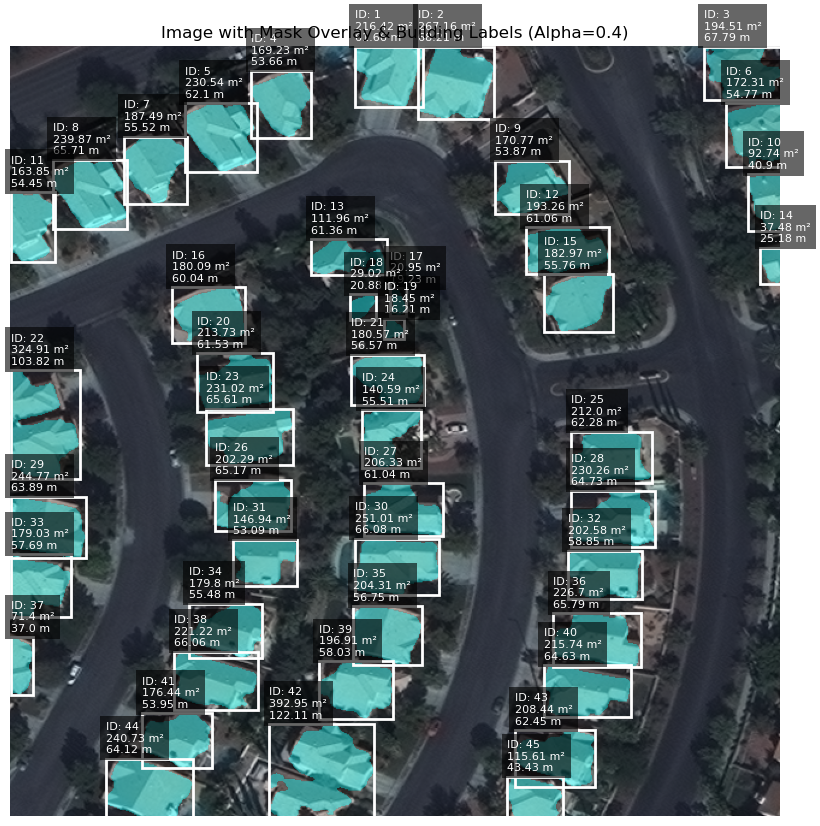

In [101]:
# Example Usage with Adjustable Transparency & Labels
image_path = "dataset/processed_images/AOI_2_Vegas_Test_public/RGB-PanSharpen-processed/RGB-PanSharpen_AOI_2_Vegas_img100.tif"
overlay_mask_with_labels(image_path, binary_preds[0, :, :, 0], alpha=0.4, mask_color='cyan')

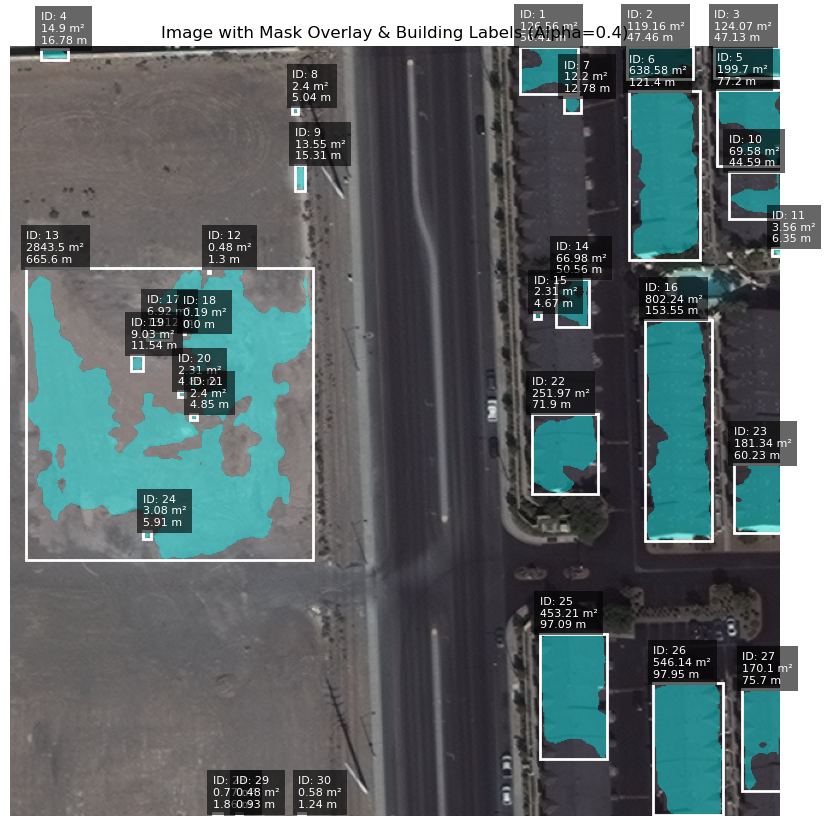

In [104]:
image_path = "dataset/processed_images/AOI_2_Vegas_Test_public/RGB-PanSharpen-processed/RGB-PanSharpen_AOI_2_Vegas_img1005.tif"
overlay_mask_with_labels(image_path, binary_preds[1, :, :, 0], alpha=0.4, mask_color='cyan') 

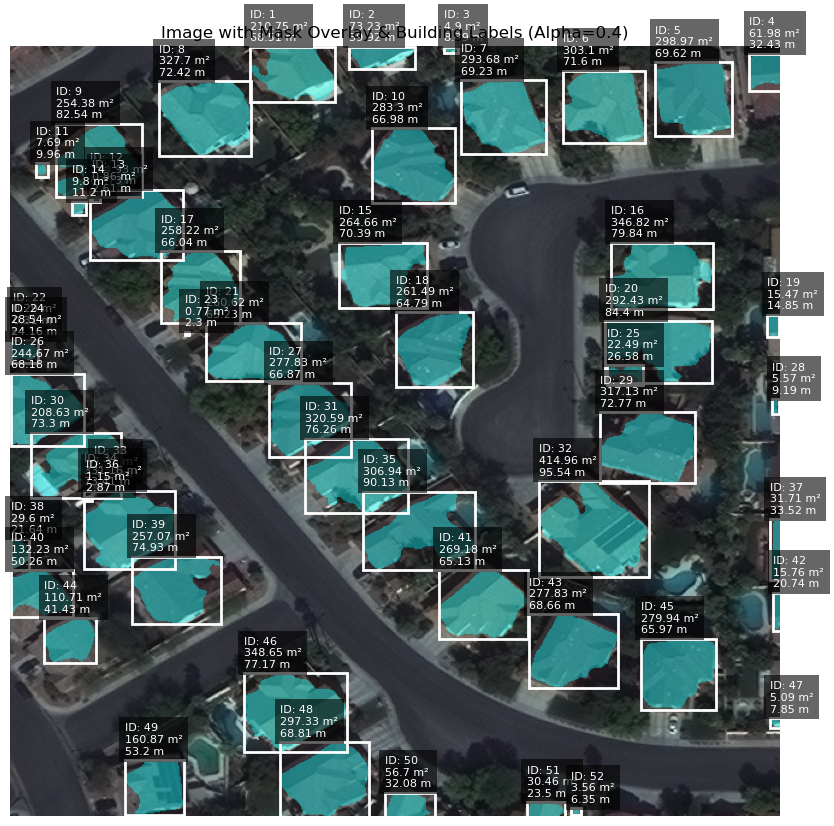

In [105]:
image_path = "dataset/processed_images/AOI_2_Vegas_Test_public/RGB-PanSharpen-processed/RGB-PanSharpen_AOI_2_Vegas_img1008.tif"
overlay_mask_with_labels(image_path, binary_preds[2, :, :, 0], alpha=0.4, mask_color='cyan') 

## References

Van Etten, A., Lindenbaum, D., & Bacastow, T.M. (2018). SpaceNet: A Remote Sensing Dataset and Challenge Series. ArXiv, abs/1807.01232.

## Snippets

Image size: 650 x 650 (Width x Height)
Number of bands: 3
CRS: EPSG:4326
Transform: | 0.00, 0.00,-115.28|
| 0.00,-0.00, 36.18|
| 0.00, 0.00, 1.00|


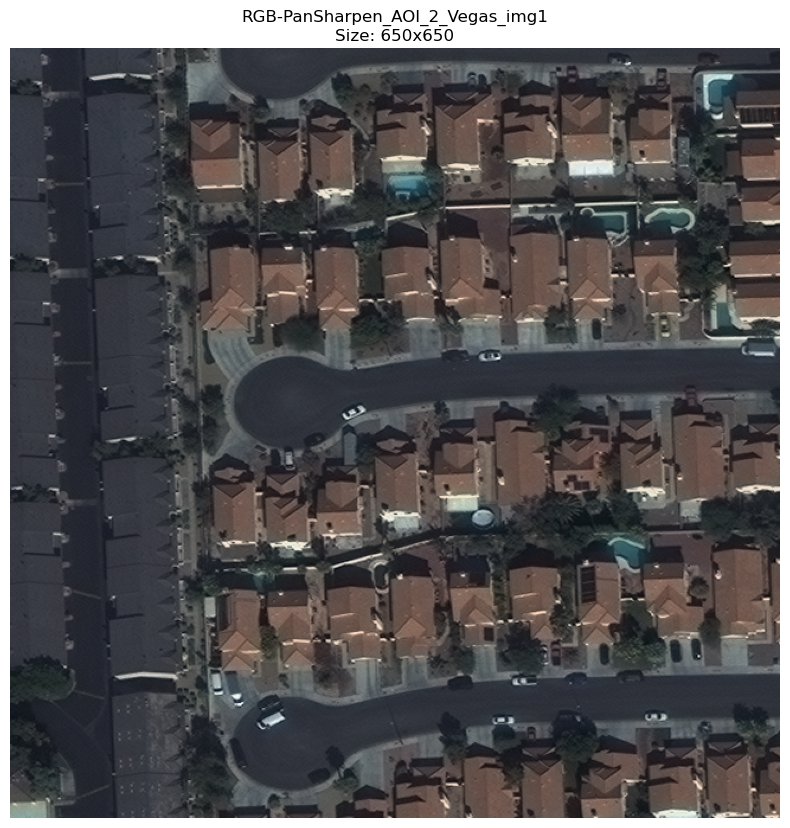

In [160]:
## Visualize the first image

import rasterio
import numpy as np
from matplotlib import pyplot as plt

# Path to the first image
image_path = "dataset/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1070.tif"

try:
    # Open the image using Rasterio
    with rasterio.open(image_path) as src:
        # Print image size and metadata
        print(f"Image size: {src.width} x {src.height} (Width x Height)")
        print(f"Number of bands: {src.count}")
        print(f"CRS: {src.crs}")
        print(f"Transform: {src.transform}")

        # Ensure the image has at least 3 bands (R, G, B)
        if src.count < 3:
            raise ValueError("The image does not have enough bands (expected at least 3).")

        # Read the first three bands (R, G, B)
        r = src.read(1)
        g = src.read(2)
        b = src.read(3)

        # Normalize each band individually to the range 0–255
        def normalize_band(band):
            return (band - band.min()) / (band.max() - band.min()) * 255

        r_normalized = normalize_band(r).astype(np.uint8)
        g_normalized = normalize_band(g).astype(np.uint8)
        b_normalized = normalize_band(b).astype(np.uint8)

        # Stack the normalized RGB bands
        rgb_normalized = np.stack((r_normalized, g_normalized, b_normalized), axis=-1)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_normalized)
    plt.title(f"RGB-PanSharpen_AOI_2_Vegas_img1\nSize: {src.width}x{src.height}")
    plt.axis("off")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file {image_path} was not found.")
except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Image size: 650 x 650 (Width x Height)
Number of bands: 3
CRS: EPSG:4326
Transform: | 0.00, 0.00,-115.28|
| 0.00,-0.00, 36.18|
| 0.00, 0.00, 1.00|


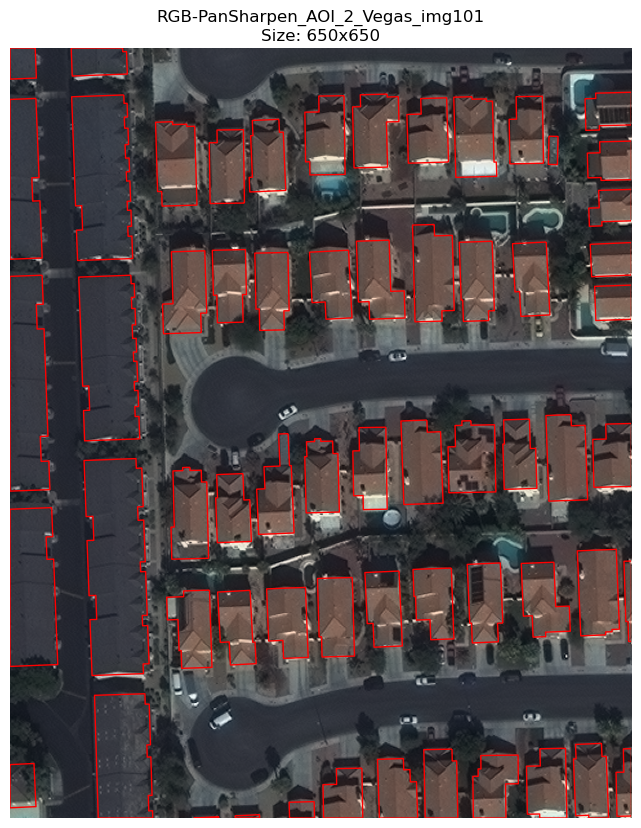

In [161]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt

# Paths to the image and geojson mask
image_path = "dataset/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1070.tif"
mask_path = "dataset/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img1070.geojson"

try:
    # Open the image using Rasterio
    with rasterio.open(image_path) as src:
        # Print image size and metadata
        print(f"Image size: {src.width} x {src.height} (Width x Height)")
        print(f"Number of bands: {src.count}")
        print(f"CRS: {src.crs}")
        print(f"Transform: {src.transform}")

        # Ensure the image has at least 3 bands (R, G, B)
        if src.count < 3:
            raise ValueError("The image does not have enough bands (expected at least 3).")

        # Read the first three bands (R, G, B)
        r = src.read(1)
        g = src.read(2)
        b = src.read(3)

        # Normalize each band individually to the range 0–255
        def normalize_band(band):
            return (band - band.min()) / (band.max() - band.min()) * 255

        r_normalized = normalize_band(r).astype(np.uint8)
        g_normalized = normalize_band(g).astype(np.uint8)
        b_normalized = normalize_band(b).astype(np.uint8)

        # Stack the normalized bands into a single array of shape (3, height, width)
        rgb_array = np.stack([r_normalized, g_normalized, b_normalized], axis=0)

        # Read the GeoJSON mask into a GeoDataFrame
        gdf = gpd.read_file(mask_path)

        # Match the GeoDataFrame's CRS to the image CRS if they differ
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Create a figure and axis for plotting
        fig, ax = plt.subplots(figsize=(10, 10))

        # Use rasterio's show function to display the georeferenced image
        show(
            rgb_array,
            transform=src.transform,
            ax=ax
        )

        # Overlay the building footprints
        # facecolor='none' makes polygons transparent, edgecolor outlines them
        gdf.plot(ax=ax, facecolor='none', edgecolor='red')

        # Set title and remove axis ticks
        plt.title(f"RGB-PanSharpen_AOI_2_Vegas_img101\nSize: {src.width}x{src.height}")
        plt.axis("off")

        # Show the figure
        plt.show()

except FileNotFoundError:
    print(f"Error: The file {image_path} or {mask_path} was not found.")
except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Image size: 650 x 650
CRS: EPSG:4326


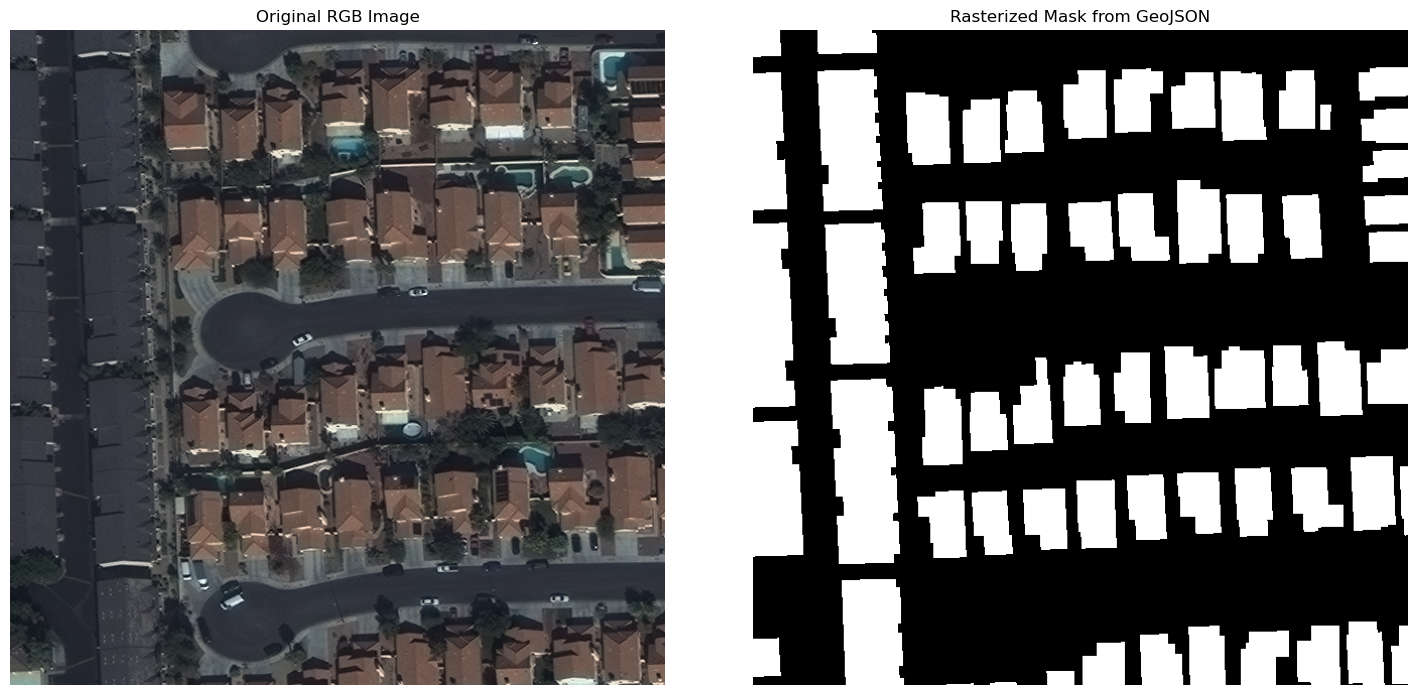

In [163]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio import features
from rasterio.plot import show

# Paths to the image and geojson
image_path = "dataset/AOI_2_Vegas_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_2_Vegas_img1070.tif"
geojson_path = "dataset/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img1070.geojson"

try:
    # 1. Open the reference image using Rasterio
    with rasterio.open(image_path) as src:
        image_crs = src.crs
        transform = src.transform
        width, height = src.width, src.height

        print(f"Image size: {width} x {height}")
        print(f"CRS: {image_crs}")

        # Read the first three bands (R, G, B) for visualization
        r, g, b = src.read(1), src.read(2), src.read(3)

        # Normalize image bands
        def normalize_band(band):
            return ((band - band.min()) / (band.max() - band.min()) * 255).astype(np.uint8)

        rgb_image = np.stack([
            normalize_band(r),
            normalize_band(g),
            normalize_band(b)
        ], axis=0)

    # 2. Load the GeoJSON and match CRS if needed
    gdf = gpd.read_file(geojson_path)
    
    if gdf.crs != image_crs:
        print(f"[Warning] GeoJSON CRS ({gdf.crs}) does not match Image CRS ({image_crs}). Reprojecting...")
        gdf = gdf.to_crs(image_crs)

    # 3. Rasterize GeoJSON to match the TIFF dimensions
    shapes = [(geom, 1) for geom in gdf.geometry if geom is not None]
    mask = np.zeros((height, width), dtype=np.uint8)

    mask = features.rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )

    # 4. Display the image and the mask
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plot the RGB image
    axes[0].set_title("Original RGB Image")
    show(rgb_image, transform=transform, ax=axes[0])
    axes[0].axis("off")

    # Plot the rasterized mask
    axes[1].set_title("Rasterized Mask from GeoJSON")
    axes[1].imshow(mask, cmap="gray")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: The file {image_path} or {geojson_path} was not found.")
except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
